<a href="https://colab.research.google.com/github/cs20m016/cs6910-Assignment-2/blob/main/PartB%5B1_3%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wandb -qq
import wandb

     |████████████████████████████████| 2.1MB 5.5MB/s 
     |████████████████████████████████| 102kB 8.3MB/s 
     |████████████████████████████████| 163kB 39.9MB/s 
     |████████████████████████████████| 133kB 32.5MB/s 
     |████████████████████████████████| 71kB 6.9MB/s 


In [2]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!unzip /content/gdrive/MyDrive/nature_12K.zip > /dev/null

In [5]:
import keras
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import os, random
import matplotlib.gridspec as gridspec
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Model
from tensorflow.keras.applications import (vgg16,resnet50,mobilenet,inception_v3,inception_resnet_v2,xception)

In [6]:
batch_size = 32
img_height = 224
img_width = 224
data_dir='/content/inaturalist_12K/train'

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9999 files belonging to 10 classes.
Using 9000 files for training.


In [8]:
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9999 files belonging to 10 classes.
Using 999 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']


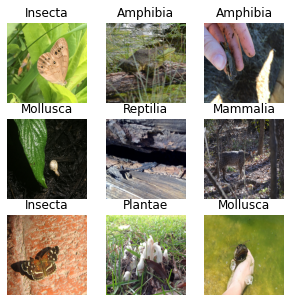

In [10]:
#sample images in training dataset
plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)

In [12]:
inception_conv = inception_v3.InceptionV3(weights='imagenet',include_top=False, input_shape=(img_height, img_width, 3))
resnet_conv = resnet50.ResNet50(weights='imagenet',include_top=False, input_shape=(img_height, img_width, 3))
mobilenet_conv = mobilenet.MobileNet(weights='imagenet',include_top=False, input_shape=(img_height, img_width, 3))
inception_resnet_conv = inception_resnet_v2.InceptionResNetV2(weights='imagenet',include_top=False, input_shape=(img_height, img_width, 3))
xception_conv = xception.Xception(weights='imagenet',include_top=False, input_shape=(img_height, img_width, 3))

83689472/83683744 [==============================] - 1s 0us/step


In [14]:
def run_model(base,in_epoch,ft_epoch,dense,act_fn,ft_bool,opt_fn,drop,base_lr):
  if base=='mobilenet':
    basemodel=mobilenet_conv
    preprocess_input = tf.keras.applications.mobilenet.preprocess_input
    if ft_bool=='Yes':
      K_ft=72
    else:
      K_ft=86
  elif base=='inception':
    basemodel=inception_conv
    preprocess_input = tf.keras.applications.inception_v3.preprocess_input
    if ft_bool=='Yes':
      K_ft=303
    else:
      K_ft=311
  elif base=='resnet':
    basemodel=resnet_conv
    preprocess_input = tf.keras.applications.resnet50.preprocess_input 
    if ft_bool=='Yes':
      K_ft=167
    else:
      K_ft=175
  elif base=='inceptionresnet':
    basemodel=inception_resnet_conv
    preprocess_input = tf.keras.applications.inception_resnet_v2.preprocess_input
    if ft_bool=='Yes':
      K_ft=772
    else:
      K_ft=780
  else:
    basemodel=xception_conv
    preprocess_input = tf.keras.applications.xception.preprocess_input
    if ft_bool=='Yes':
      K_ft=124
    else:
      K_ft=132
  
  data_augmentation = keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal"),layers.experimental.preprocessing.RandomRotation(0.1)])
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  dense_layer = tf.keras.layers.Dense(dense,activation=act_fn)
  prediction_layer = tf.keras.layers.Dense(10,activation='softmax')
  
  inputs = tf.keras.Input(shape=(img_height, img_width, 3))
  x = data_augmentation(inputs)
  x = preprocess_input(x)
  x = basemodel(x, training=False)
  x = global_average_layer(x)
  x = tf.keras.layers.Dropout(drop)(x)
  x = dense_layer(x) 
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)
 
  basemodel.trainable=False

  base_lr = 0.0001
  if opt_fn=='adam':
    opt = tf.keras.optimizers.Adam(lr=base_lr)
  else:
    opt = tf.keras.optimizers.SGD(lr=base_lr)

  model.compile(optimizer=opt,
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  
  history = model.fit(train_ds,epochs=in_epoch,validation_data=valid_ds)

  basemodel.trainable=True
  for layer in basemodel.layers[:K_ft]:
    layer.trainable=False


  if opt_fn=='adam':
    opt_ft = tf.keras.optimizers.Adam(lr=base_lr/10)
  else:
    opt_ft = tf.keras.optimizers.SGD(lr=base_lr/10)
  model.compile(optimizer=opt_ft,
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  
  early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, min_delta=0.001, mode='max')

  tot_epoch=ft_epoch+in_epoch
  history_ft = model.fit(train_ds,validation_data=valid_ds,epochs=tot_epoch,initial_epoch=history.epoch[-1]+1,callbacks=[early_stopping])

  acc=history.history['accuracy']+history_ft.history['accuracy']
  loss=history.history['loss']+history_ft.history['loss']
  val_acc=history.history['val_accuracy']+history_ft.history['val_accuracy']
  val_loss=history.history['val_loss']+history_ft.history['val_loss']

  epochs_range = len(acc)
  for i in range(epochs_range):
    wandb.log({'accuracy': acc[i]})
    wandb.log({'val_accuracy': val_acc[i]})
    wandb.log({'loss': loss[i]})
    wandb.log({'val_loss': val_loss[i]})
  wandb.log({'model_accuracy': max(val_acc)})
  return

In [16]:
sweep_config = {
    'method': 'random',
    'metric': {
      'name': 'model_accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'base':{
            'values':['inception','resnet','inceptionresnet','xception']
        },
        'in_epoch': {
            'values': [4]
        },
        'ft_epoch':{
            'values':[4]
        },
        'ft_bool':
        {
            'values':['Yes','No']
        },
        'dropout':{
            'values': [0.1,0.2]
        },
        'learning_rate':{
            'values': [0.001,0.0001]
        },
        'optimizer_fn':{
            'values': ['adam','sgd']
        },
        'activation_fn':{
            'values': ['relu','tanh']
        },
        'dense':{
            'values': [256,512]
        }
    }
}

In [18]:
sweep_id = wandb.sweep(sweep_config,entity="dlassignment2",project="Part-B")

Create sweep with ID: 5cgpm2xm
Sweep URL: https://wandb.ai/dlassignment2/Part-B/sweeps/5cgpm2xm


In [17]:
def train():
  config_defaults={
        'base':'xception',
        'in_epoch':5,
        'ft_epoch':5,
        'ft_bool':'Yes',
        'dropout':0.1,
        'learning_rate':0.0001,
        'optimiser_fn':'adam',
        'activation_fn':'relu',
        'dense':256   
        }
  # Initialize a new wandb run
  wandb.init(config=config_defaults)
    
  # Config is a variable that holds and saves hyperparameters and inputs
  config = wandb.config

  run_model(config.base,config.in_epoch,config.ft_epoch,config.dense,config.activation_fn,config.ft_bool,config.optimiser_fn,config.dropout,config.learning_rate)
  return

In [ ]:
wandb.agent(sweep_id, train,count=1)

wandb: Agent Starting Run: cdqas0js with config:
wandb: 	activation_fn: tanh
wandb: 	base: xception
wandb: 	dense: 256
wandb: 	dropout: 0.1
wandb: 	ft_bool: No
wandb: 	ft_epoch: 4
wandb: 	in_epoch: 4
wandb: 	learning_rate: 0.001
wandb: 	optimizer_fn: adam
wandb: Currently logged in as: athirapt (use `wandb login --relogin` to force relogin)


Epoch 1/4
  1/282 [..............................] - ETA: 1:04:54 - loss: 2.4382 - accuracy: 0.0938